<div style="text-align: center;">Ghouila Mohamed - Chambon Thomas - Medbouhi Adam - Cornuejouls Damien</div>

# **Projet 2 : Conditional Variational Auto-Encoder sur les données FashionMNIST**

In [1]:
# Imports des librairies
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import triplet_margin_loss
from torch.nn.functional import pairwise_distance
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Les deux lignes de commande suivantes permettent, à l'aide d'une routine de *torchvision.datasets*, de récupérer deux jeux de données FashionMNIST. Les images sont en **gris** (1 channel) et de **taille 28x28**.

In [2]:
# Chargement des données FashionMNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)


00%|██████████████████████████████████████████████████████████████████| 26421880/26421880 [00:21<00:00, 1203315.74it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




00%|█████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 789780.17it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




00%|████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 1723654.73it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 8911381.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## **Variables globales**

In [3]:
BATCH_SIZE = 128
MAX_EPOCHS = 10
LEARNING_RATE = 1e-3
CLASSES_TO_IDX = train_dataset.class_to_idx
IDX_TO_CLASSES = {idx: cls for cls, idx in CLASSES_TO_IDX.items()}
FEATURE_SIZE = train_dataset.data[0].shape[0] # 28
CLASS_SIZE = 10
LATENT_SIZE = 20
NUM_CHANNELS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## **Analyse Exploratoire**

### a. Visualisation de chaque classe

Ici, on crée un DataLoader temporaire afin de pouvoir afficher un élément de chaque classe. L'objectif, avoir une idée de la visualisation des différents habits.

In [4]:
def plot_random_samples_per_class(dataset, idx_to_class=IDX_TO_CLASSES):
    samples = {i: None for i in range(10)}
    temp_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Itère sur le DataLoader
    for img, label in temp_loader:
        label = label.item()
        if samples[label] is None:  # Selection du premier élément de chaque classe
            samples[label] = img
        if all(v is not None for v in samples.values()):  # On stop dés lors que qu'on a un échantillon de chaque classe
            break

    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Echantillon aléatoire de FashionMNIST")

    # Affichage de chaque image sur son subplot associé
    for i, (label, img) in enumerate(samples.items()):
        ax = axes[i // 5, i % 5]  # Position in the grid
        ax.imshow(img.squeeze(), cmap="gray")
        ax.set_title(idx_to_class[label])
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

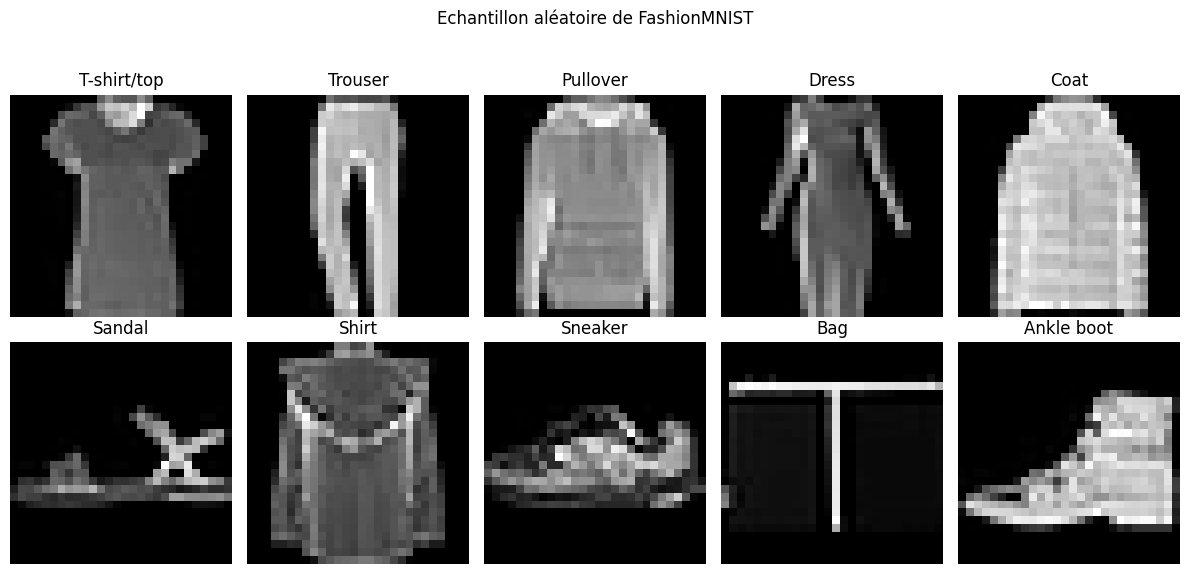

In [5]:
plot_random_samples_per_class(train_dataset)

Comme constaté plus haut, il y a 10 classes différentes. On remarque par ailleurs qu'il y a plusieurs types de chaussures et de hauts, ayant parfois des designs assez ressemblants. On imagine alors que l'une des difficultés de la tâche de reconstruction va être de ne pas confondre certains items entre eux (ex : *Pullover* et *Shirt*). On va poursuivre l'analyse exploratoire sur ces jeux de données, à l'aide d'outils de visualisation.

### b. Répartition des classes

In [6]:
def plot_class_distribution(train_dataset, test_dataset, idx_to_class=IDX_TO_CLASSES):
    print(f"Les jeux de données sont taille {len(train_dataset)} (train) et {len(test_dataset)} (test).")

    # Compter les labels dans les datasets
    train_counts = Counter([label for _, label in train_dataset])
    test_counts = Counter([label for _, label in test_dataset])

    # Extraire les classes et leurs décomptes
    train_labels, train_values = zip(*sorted(train_counts.items()))
    test_labels, test_values = zip(*sorted(test_counts.items()))

    # Vérifier que les labels correspondent entre train et test
    assert train_labels == test_labels, "Les classes des datasets diffèrent."

    # Configuration du plot
    x = range(len(train_labels))
    width = 0.4  # Largeur des barres

    plt.figure(figsize=(12, 6))

    # Histogrammes
    plt.bar(x, train_values, width, label="Train", color="skyblue", edgecolor="black")
    plt.bar([p + width for p in x], test_values, width, label="Test", color="orange", edgecolor="black")

    # Ajouter les labels, titre et légende
    plt.xticks([p + width / 2 for p in x], [idx_to_class[label] for label in train_labels], rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'exemples")
    plt.title("Répartition des classes dans les datasets Train et Test")
    plt.legend()

    # Afficher
    plt.tight_layout()
    plt.show()


Les jeux de données sont taille 60000 (train) et 10000 (test).


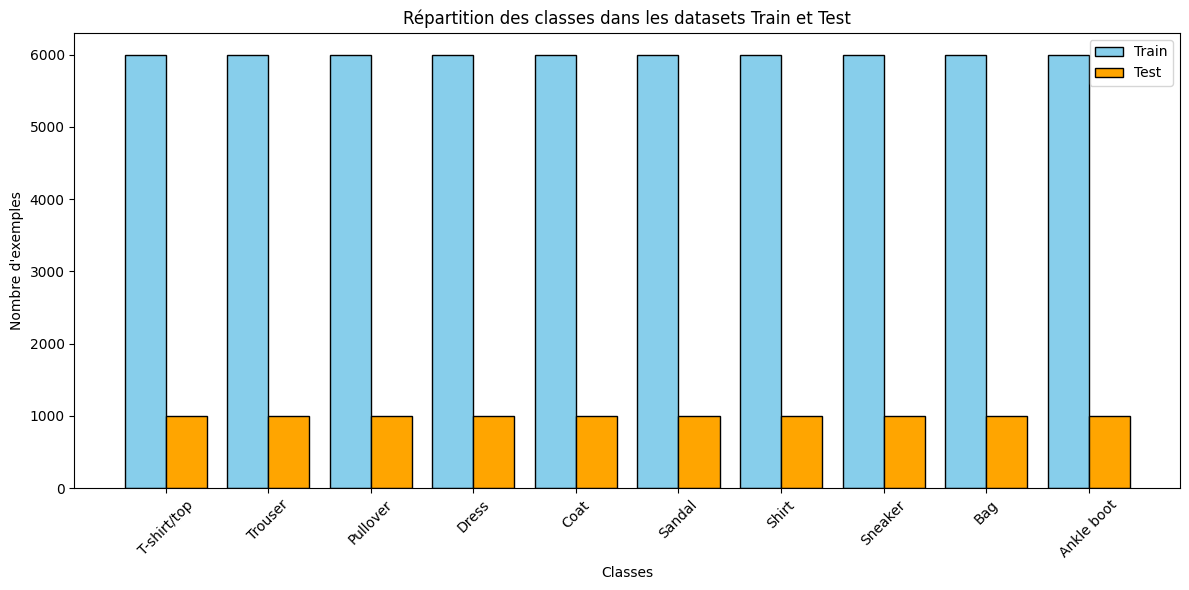

In [7]:
plot_class_distribution(train_dataset, test_dataset)

Il est clair que les classes sont uniformément distribuées. Cela est une bonne nouvelle pour la suite. A priori, il sera inutile d'utiliser une *Focal Loss*, dont les poids seraient à adapter en fonction des proportions d'éléments de chaque classe.

### c. PCA et TSNE

Il est intéressant de réaliser une PCA/TSNE car le but général d'un Auto-Encoder est de représenter au mieux nos données dans un espace *latent*. Il s'agit en quelque sorte d'une extension **non-linéaire** (dûe notamment aux fonctions d'activation) d'une PCA. Si une PCA permet de représenter correctement nos données, alors on peut espérer obtenir de bonnes performances avec notre Auto-Encoder.

In [8]:
def visualize_dim_reduction(dataset, n_samples=1000, idx_to_class=IDX_TO_CLASSES):
    # Limiter le nombre d'échantillons
    n_samples = min(n_samples, len(dataset))

    # Extraire les données et labels
    data = dataset.data[:n_samples].numpy()  # Convertir en NumPy
    labels = dataset.targets[:n_samples].numpy()  # Convertir les cibles en NumPy

    # Aplatir les images 28x28 en vecteurs 1D
    data = data.reshape(n_samples, -1)

    # Réduction avec PCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)

    # Réduction avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)

    # Visualisation côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3})

    # Plot PCA
    scatter = axes[0].scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap="tab10", alpha=0.7)
    axes[0].set_title("Réduction avec PCA")
    axes[0].set_xlabel("Composante 1")
    axes[0].set_ylabel("Composante 2")

    # Plot t-SNE
    scatter = axes[1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap="tab10", alpha=0.7)
    axes[1].set_title("Réduction avec t-SNE")
    axes[1].set_xlabel("Composante 1")
    axes[1].set_ylabel("Composante 2")

    # Ajouter une légende pour les couleurs
    class_names = idx_to_class.values()
    cbar = fig.colorbar(scatter, ax=axes, orientation="vertical", fraction=0.03, pad=0.04)
    cbar.set_label("Classes")
    cbar.set_ticks(range(len(class_names)))  # Positionner les ticks
    cbar.set_ticklabels(class_names)

    plt.show()

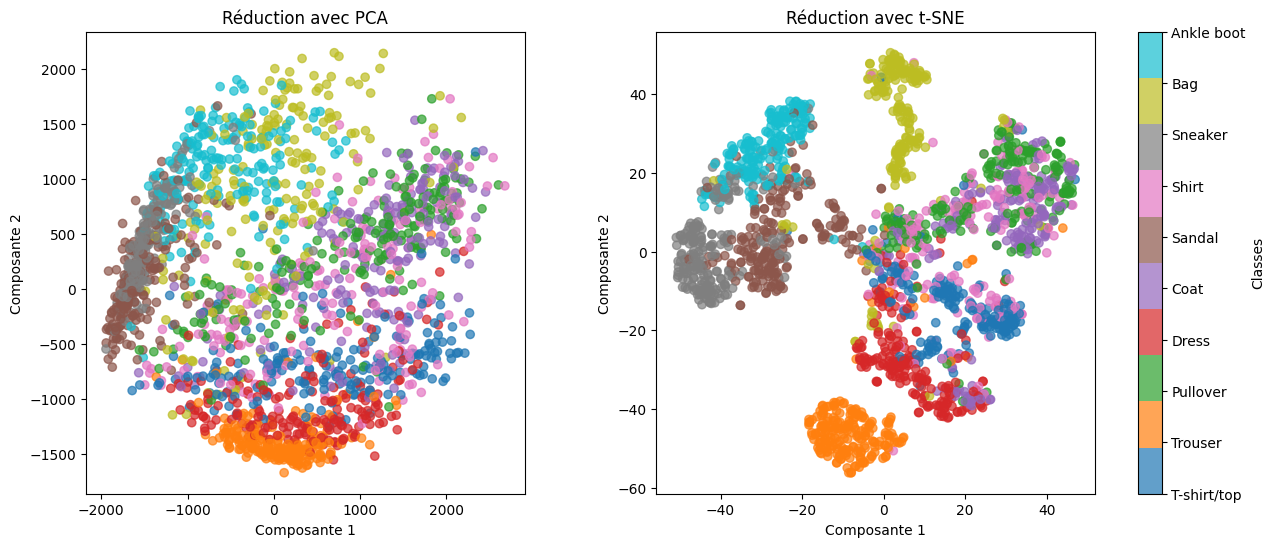

In [9]:
visualize_dim_reduction(train_dataset, n_samples=2000)

Plusieurs choses sont notables. Tout d'abord, globalement le TSNE semble mieux séparer les classes. Pour rappel le TSNE minimise une fonction de coût appelée **divergence de Kullback-Leibler (KL)**. Certaines sont même disjointes du reste des autres classes comme *Trouser*. Cependant, nos hypothèses préalables quant à la difficulté de séparer des classes aux caractéristiques visuelles proches se confirment. En effet, on observe qu'il est compliqué (pour les deux analyses PCA et TSNE) de séparer les classes *Pullover*, *Shirt* et *Coat*, visuellement proches. Ainsi, nous allons tenter de concevoir et entraîner un CVAE capable de mieux les distinguer. Par la même occasion, de part le coté variationnel de l'encoder, on pourra même en générer.

## **Construction des DataLoaders**

Dans cette section on forme les DataLoaders nécessaires à l'entraînement de nos modèles. On crée un jeu de validation à partir du jeu de test. Essentiellement, les données de validation permettent d'anticiper le sur-apprentissage du modèle, et de constater que celui-ci "apprend".

In [10]:
# Split test between validation and test
val_size = int(test_dataset.data.shape[0] / 2)
test_size = test_dataset.data.shape[0] - val_size
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

# Some prints
print(f"Train dataset size: {len(train_dataset.data)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Makes dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Train dataset size: 60000
Validation dataset size: 5000
Test dataset size: 5000


## **Conditional Variational Auto-Encoder**

Le principe d'un CVAE ne diffère que peu de celui d'un VAE. L'idée, tirer partie du jeu de données *labélisé*. Pour cela, on va fournir en entrée de l'encodeur **et** du décodeur les labels. Le schéma suivant résume son fonctionnement :

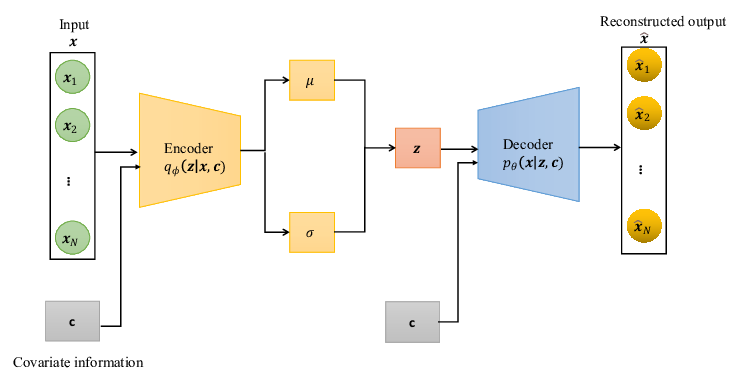

*Crédits :* [*Abdelli, Khouloud & Griesser, Helmut & Neumeyr, Christian & Hohenleitner, Robert & Pachnicke, Stephan. (2022). Degradation Prediction of Semiconductor Lasers using Conditional Variational Autoencoder.*](https://www.researchgate.net/figure/Structure-of-the-conditional-variational-autoencoder-CVAE_fig2_365190062)

## **Fully Connected Conditional Variational Auto-Encoder**

Une première idée est d'utiliser un auto-encoder avec des couches Fully Connected. C'est l'objectif de ce modèle.

In [11]:
class CVAE(nn.Module):
    def __init__(self, feature_size=FEATURE_SIZE, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(CVAE, self).__init__()
        self.feature_size = feature_size

        # encode
        self.fc1  = nn.Linear(feature_size * feature_size + num_classes, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + num_classes, 400)
        self.fc4 = nn.Linear(400, feature_size * feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x, c): # Q(z|x, c)
        inputs = torch.cat([x, c], 1)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, z, c): # P(x|z, c)
        inputs = torch.cat([z, c], 1)
        h3 = self.elu(self.fc3(inputs))
        recon = self.sigmoid(self.fc4(h3))
        return recon.view(inputs.size(0), 1, self.feature_size, self.feature_size)

    def forward(self, x, c):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encoder(x, c)
        z = self.sample(mu, logvar)
        return self.decoder(z, c), z, mu, logvar

*Crédits :* [*Vadim Borisov*](https://github.com/unnir/cVAE/blob/master/cvae.py)

## **Convolutional Conditional Variational Auto-Encoder**

Pour tirer partie de l'organisation spatiale de nos images, on a décidé de poursuivre avec un modèle un peu plus complexe, qui utilise des couches de convolution. Il est intéressant de noter que le nombre de paramètres est nécessairement moins grand que dans le modèle précédent.

In [12]:
class Encoder(nn.Module):
    def __init__(self, num_channels=NUM_CHANNELS, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc_mu = nn.Linear(64 * 7 * 7 + num_classes, latent_size)
        self.fc_logvar = nn.Linear(64 * 7 * 7 + num_classes, latent_size)

    def forward(self, x, y):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.cat([x, y], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, num_channels=NUM_CHANNELS, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size + num_classes, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(32, num_channels, kernel_size=4, stride=2, padding=1)  # 14x14 -> 28x28

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        x = F.relu(self.fc(z))
        x = x.view(x.size(0), 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

class ConvCVAE(nn.Module):
    def __init__(self, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(ConvCVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, y)
        return x_recon, z, mu, logvar

## **Fonctions de perte**

On a décidé d'utiliser plusieurs *loss* pour l'entrainement des modèles. On vise alors plusieurs objectifs simultanément :

*   Reconstruire l'image fournie correctement avec un terme de reconstruction : **Mean Square Error**
*   Rendre le modèle suffisamment insensible aux entrées pour éviter le sur-apprentissage : **Divergence KL**
*   Trouver un espace latent dans lequel des entrées aux classes similaires seraient proches. Inversement, des entrées aux labels différents suffisamment éloignées : ***Constrastive*** ou ***InfoNCE***

La fonction *total_loss* nous permet de choisir les termes à considérer. On conserve systématiquement le terme de reconstruction et de régularisation mais on peut choisir de rajouter l'une des deux dernières *loss* ou pas.


In [55]:
def contrastive_loss(z, y, margin=0.2):
    # Calculer les distances par paires
    pairwise_distances = torch.cdist(z, z, p=2)  # Matrice des distances

    # Étendre y pour comparer toutes les paires
    y = y.unsqueeze(1)
    matches = (y == y.T).float()  # Matrice 1 si même classe, 0 sinon

    # Calcul de la perte
    positive_loss = matches * (pairwise_distances ** 2)
    negative_loss = (1 - matches) * torch.clamp(margin - pairwise_distances, min=0) ** 2

    # Moyenne sur toutes les paires
    loss = (positive_loss + negative_loss).mean()
    return loss

def InfoNCE_loss(z, y, temperature=0.1):
    # Normalisation des vecteurs latents
    z = F.normalize(z, dim=1)

    # Produit scalaire pour obtenir la similarité
    logits = torch.mm(z, z.t()) / temperature

    # Création de masques pour les étiquettes correspondantes
    labels = (y.unsqueeze(1) == y.unsqueeze(0)).float()

    # Loss InfoNCE
    log_prob = F.log_softmax(logits, dim=1)
    loss = -(labels * log_prob).sum(dim=1).mean()
    return loss

In [56]:
def total_loss(recon_x, x, mu, logvar, z, y, beta=1.0, alpha_contrast=1.0, add_contrastive=False, alpha_nce=1.5, add_nce=True):
    # Terme de reconstruction
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0) # BCE plutôt qu'une MSE

    # D_KL entre q(z|x) (approximative) et p(z) (prior)
    # Si on suppose q(z|x) ~ N(mu, exp(log_var)), et p(z) ~ N(0, I)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    # Loss totale
    total_loss = recon_loss + beta * kld_loss

    # Ajout du terme contrastive si voulu
    if add_contrastive:
        contrast_loss = contrastive_loss(z, y)
        total_loss += alpha_contrast * contrast_loss

    # Ajout du terme InfoNCE si voulu
    if add_nce:
        nce_loss = InfoNCE_loss(z, y)
        total_loss += alpha_nce * nce_loss

    return total_loss

## **Fonctions utiles**

Le principe de la fonction *one-hot* est de remplacer les valeurs de nos labels par des indicatrices. Concrétement cela facilite la concaténation avec les entrées de l'encodeur/decodeur :

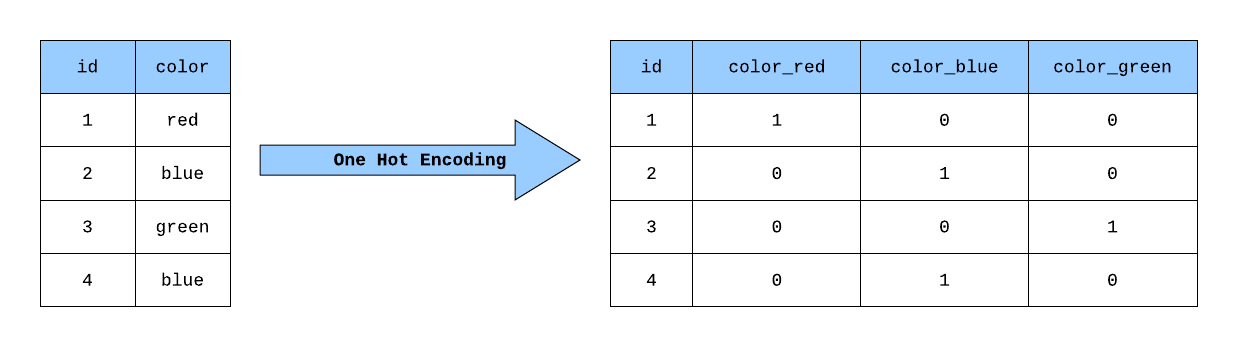

*Crédits :* [*George Novack (2020). Building a One Hot Encoding Layer with TensorFlow.*](https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)

In [15]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(DEVICE)

La fonction suivante nous permet de récupérer la valeur du *Learning Rate* à tout instant de l'entrainement. Cette fonction est utile quand on emploie un *LR scheduler*. Il est fréquent d'employer des *LR* variables. Par exemple, il est possible d'en utiliser des cycliques. L'avantage étant de se libérer de zones de minimas locaux.

In [16]:
def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

## **Phase d'entrainement**

La fonction d'entrainement est assez complète. Elle réalise les boucles d'entrainement et de validation. On a la possibilité de préciser un *LR* variable et de sauvegarder le modèle après entrainement.

In [57]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device=DEVICE,
    scheduler=None,
    max_epochs=MAX_EPOCHS,
    num_classes=CLASS_SIZE,
    save_model=False,
    save_path="cvae_weights.pt"
):
    model = model.to(device)
    train_loss_l = torch.zeros(max_epochs)
    val_loss_l = torch.zeros(max_epochs)

    for epoch in range(1, max_epochs + 1):
        # ** Training **
        model.train()
        running_train_loss = 0.0
        for data, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs} Training"):
            data, labels = data.to(device), labels.to(device)
            if num_classes is not None:
                labels_one_hot = one_hot(labels, num_classes)

            # Forward pass
            optimizer.zero_grad()
            recon_data, z, mu, logvar = model(data, labels_one_hot)

            # Calcul de loss
            loss = total_loss(recon_data, data, mu, logvar, z, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader)

        # ** Validation **
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{max_epochs} Validation"):
                data, labels = data.to(device), labels.to(device)
                if num_classes is not None:
                    labels_one_hot = one_hot(labels, num_classes)

                # Forward pass
                recon_data, z, mu, logvar = model(data, labels_one_hot)

                loss = total_loss(recon_data, data, mu, logvar, z, labels)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)

        # Sauvegarde des Losses
        train_loss_l[epoch - 1] = train_loss
        val_loss_l[epoch - 1] = val_loss

        # Affichage des losses
        print(f"Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Mise à jour du LR
        if scheduler:
            print(f"Learning Rate: {get_lr(optimizer):.6f}")
            scheduler.step()

    # Enregistrement du modèle entraine
    if save_model:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    return train_loss_l, val_loss_l



poch 1/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 52.52it/s]

Epoch 1, Training Loss: 374.8982, Validation Loss: 335.9489




poch 2/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.62it/s]

Epoch 2, Training Loss: 329.5288, Validation Loss: 326.1428




poch 3/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.50it/s]

Epoch 3, Training Loss: 322.8090, Validation Loss: 321.8825




poch 4/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 45.80it/s]

Epoch 4, Training Loss: 320.2525, Validation Loss: 319.4126




poch 5/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 52.06it/s]

Epoch 5, Training Loss: 318.8823, Validation Loss: 317.8176




poch 6/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 52.46it/s]

Epoch 6, Training Loss: 317.3633, Validation Loss: 316.9360




poch 7/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 54.66it/s]

Epoch 7, Training Loss: 316.6017, Validation Loss: 316.2666




poch 8/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.10it/s]

Epoch 8, Training Loss: 315.9562, Validation Loss: 315.8184




poch 9/11 Validation: 100%|████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 52.67it/s]

Epoch 9, Training Loss: 315.1332, Validation Loss: 315.0115




poch 10/11 Validation: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 53.18it/s]

Epoch 10, Training Loss: 314.8559, Validation Loss: 315.0522




poch 11/11 Validation: 100%|███████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 54.57it/s]

Epoch 11, Training Loss: 314.3667, Validation Loss: 314.5474
Model saved to cvae_weights.pt


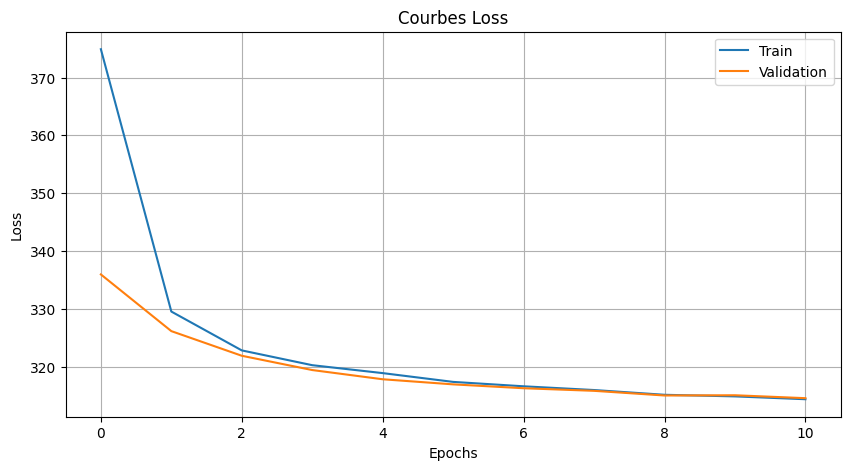

In [58]:
cvae = ConvCVAE()
optimizer = torch.optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

# Fonction Train
train_loss, val_loss = train_model(
    model=cvae,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=None,
    save_model=True,
    max_epochs=11,
)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.title("Courbes Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Après de nombreux tests, on a choisi d'ajouter une *InfoNCE loss*, qui rend l'espace latent bien plus structuré, tout en permettant une bonne qualité de reconstruction. Il a été observé que la *contrastive loss* ne permet pas suffisamment la séparation des classes dans l'espace latent. Aussi, les hyperparamètres choisis (taille de *batch* et nombre d'*epochs*) ont été ajustés au fil des expérimentations. De façon générale, on cherche avoir une grande taille de *batch* (à la limite de la capacité de notre RAM). Concernant les courbes de loss, on constate que celles-ci ont bien convergé sans conduire à un sur-ajustement. Ceci justifie le nombre d'*epochs* choisi (11).

## **Phase de test**

Cette fonction de test est assez classique. Elle se veut d'être modulable et permet l'affichage de l'espace latent appris par le modèle. On peut aussi lui préciser les dimensions de l'espace qu'on souhaite afficher. En effet, peut-être que les données sont très mal représentées dans un couple de dimensions et bien mieux dans un autre.

In [94]:
def test_model(
    model,
    test_loader,
    device=DEVICE,
    num_classes=CLASS_SIZE,
    plot_latent_space=True,
    cmap="tab10",
    dim1_latent=0,
    dim2_latent=1,
    idx_to_class=IDX_TO_CLASSES,
):
    # Envoi du modèle sur GPU
    model = model.to(device)
    model.eval()

    running_test_loss = 0.0
    total_mse = 0.0
    residuals_sum = 0

    # Init plot
    if plot_latent_space:
        fig, ax = plt.subplots()
        scatter = ax.scatter([], [], c=[], cmap=cmap, vmin=0, vmax=num_classes - 1)

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Testing..."):
            data, labels = data.to(device), labels.to(device)
            if num_classes is not None:
                labels_one_hot = one_hot(labels, num_classes)

            # Forward pass
            recon_data, z, mu, logvar = model(data, labels_one_hot)
            loss = total_loss(recon_data, data, mu, logvar, z, labels)

            # Mean Squared Error
            mse_value = F.mse_loss(recon_data, data, reduction='sum')
            total_mse += mse_value.item()
            residuals_sum += torch.abs(data - recon_data).sum(dim=0)

            running_test_loss += loss.item()

            # Mise à jour du plot
            if plot_latent_space:
                mu, labels = mu.cpu(), labels.cpu()
                scatter = ax.scatter(
                    mu[:, dim1_latent], mu[:, dim2_latent], c=labels, cmap=cmap, vmin=0, vmax=num_classes - 1
                )

    # Calculs finaux
    test_loss = running_test_loss / len(test_loader)
    mse = total_mse / len(test_loader.dataset)

    print(f"Test loss: {test_loss:.4f} -- MSE: {mse:.4f}")

    if plot_latent_space:
        class_names = idx_to_class.values()
        cbar = plt.colorbar(scatter)
        cbar.set_label("Classes")
        cbar.set_ticks(range(len(class_names)))  # Positionner les ticks
        cbar.set_ticklabels(class_names)
        plt.title("Espace Latent")
        plt.show()

    return test_loss, mse, residuals_sum


esting...: 100%|██████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 125.79it/s]

Test loss: 256.4054 -- MSE: 11.8871


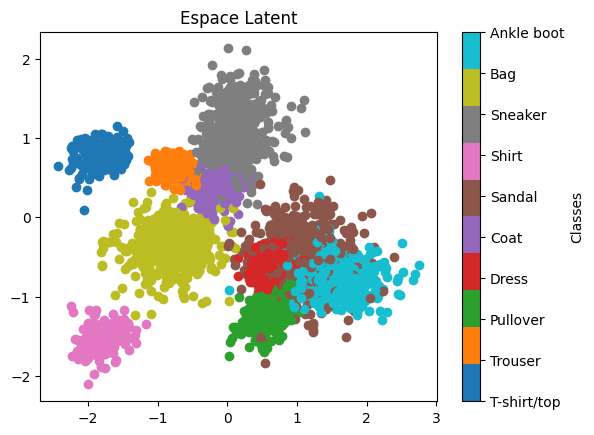

In [95]:
cvae = ConvCVAE()
cvae.load_state_dict(torch.load("cvae_weights.pt", weights_only=True))

# Fonction test
test_loss, mse, residuals_sum = test_model(
    model=cvae,
    test_loader=test_loader,
    dim1_latent=0,
    dim2_latent=1,
)

La valeur de la *loss* est relativement faible comparée aux valeurs obtenues lors des phases de validation. La valeur de la *MSE* est légèrement élevée mais il est difficile de se rendre compte de l'erreur commise. Les plots de la partie suivante permettent de répondre en partie à cette problématique. L'espace latent est quant à lui très bon. Il permet de séparer correctement les classes entre elles. Le modèle est même parvenu à séparer des classes aux caractéristiques visuelles proches, ce que la PCA peinait à faire.

## **Qualité de reconstruction**

Pour avoir une idée plus visuelle de la qualité de reconstruction de notre modèle, on décide de *plot* quelques images d'origine avec leur reconstruction associée.

In [96]:
def compute_plot_test(
    model,
    test_loader,
    device=DEVICE,
    num_classes=CLASS_SIZE,
    classes=IDX_TO_CLASSES,
    batch_size=1,
    cmap="gray",
    figsize=(12, 12),
    num_samples=5
):
    model = model.to(device)
    model.eval()
    mse_values = []
    
    fig, axs = plt.subplots(nrows=num_samples, ncols=2, figsize=figsize)
    loader_iter = iter(test_loader)

    if num_samples > len(test_loader.dataset):
        print("Reduce the batch-size or the num_samples value!")
        return

    with torch.no_grad():
        for row in range(num_samples):
            data, labels = next(loader_iter)
            data, labels = data.to(device), labels.to(device)
            if num_classes is not None:
                labels_one_hot = one_hot(labels, num_classes)

            recon_data, _, _, _ = model(data, labels_one_hot)

            # Choix d'un échantillon
            if batch_size > 1:
                idx = random.randint(0, batch_size - 1)
            else:
                idx = 0

            # MSE
            original = data[idx]
            reconstructed = recon_data[idx]
            mse_values.append(F.mse_loss(reconstructed, original, reduction='sum').item())

            # Move vers le cpu
            original = original.cpu().squeeze()
            reconstructed = reconstructed.cpu().detach().squeeze()
            label_idx = labels[idx] if num_classes else -1
            label_name = classes[label_idx.item()] if classes else f"Class {label_idx}"

            # Plot
            axs[row, 0].imshow(original, cmap=cmap)
            axs[row, 0].set_title(f"Original: {label_name}")
            axs[row, 0].axis("off")

            axs[row, 1].imshow(reconstructed, cmap=cmap)
            axs[row, 1].set_title("Reconstructed")
            axs[row, 1].axis("off")

    plt.tight_layout()
    plt.show()

    return mse_values

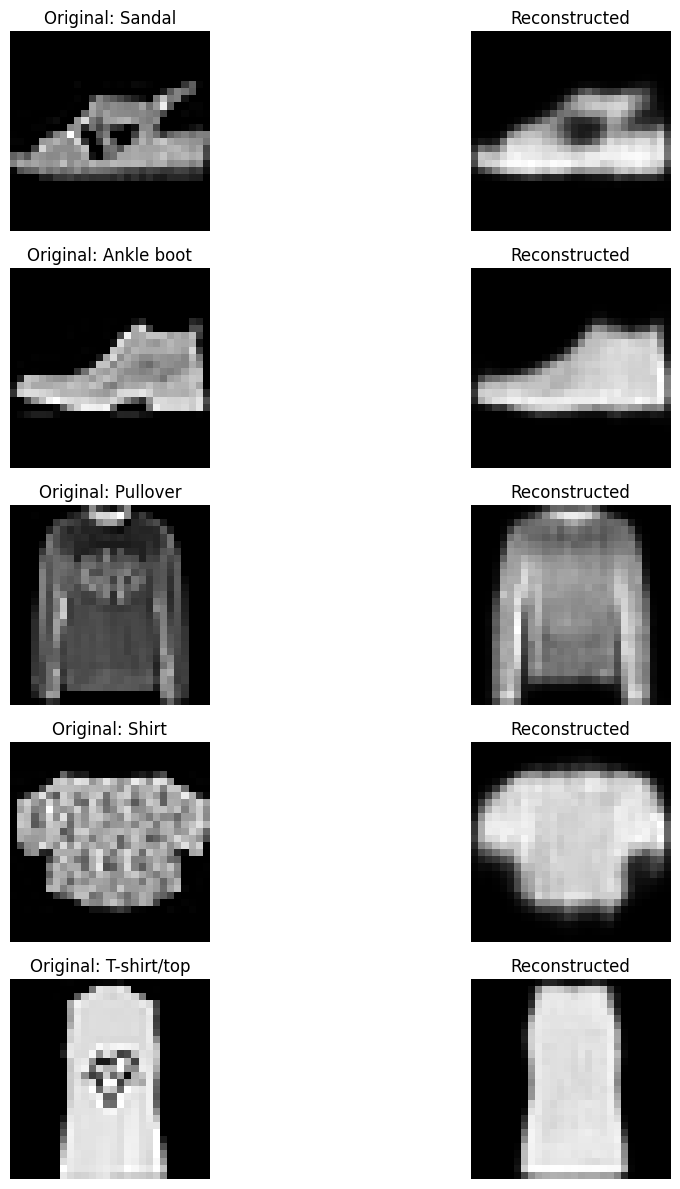

MSE entre les images du jeu de test: [12.415674209594727, 9.408958435058594, 10.585587501525879, 18.113082885742188, 12.75235652923584]


In [97]:
mse = compute_plot_test(cvae, test_loader)
print(f"MSE entre les images du jeu de test: {mse}")

Les représentations associées aux scores *MSE* sont déjà plus parlantes. De manière générale le modèle parvient à reformer la structure globale de l'objet. Cependant, quand il s'agit de détails un peu plus poussés, ce dernier a du mal. Ceci se constate aisément sur le *T-Shirt/top* affiché ou encore sur la *Sandal*.

## **Génération d'échantillons**

Cette étape de *sampling* est cruciale dans la validation d'un modèle type VAE. En effet l'intérêt des VAE et de son côté stochastique est la génération de nouveaux échantillons. Dans le cas d'un CVAE, on va voir si le modèle sait suffisamment tirer partie des labels fournis en entrée du décodeur pour construire un type d'habit particulier.

In [91]:
def generate_and_plot_samples(model, num_samples=5, idx_to_class=IDX_TO_CLASSES, latent_size=LATENT_SIZE, feature_size=FEATURE_SIZE, device=DEVICE):
    class_names = list(idx_to_class.values())
    
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(16, 10))
    fig.suptitle("Échantillons générés par classe", fontsize=16)

    # Envoi du modèle sur le GPU
    model = model.to(device)
    model.eval()

    for class_idx in range(len(class_names)):
        # Créer un vecteur one-hot pour la classe actuelle
        one_hot_class = one_hot(torch.tensor([class_idx]), len(class_names))
        one_hot_class = one_hot_class.repeat(num_samples, 1)  # Répéter pour chaque échantillon

        # Générer des échantillons aléatoires dans l'espace latent
        z = torch.randn(num_samples, latent_size, device=device)

        # Générer des images à partir de chaque échantillon latent
        with torch.no_grad():
            generated_images = model.decoder(z, one_hot_class)

        # Afficher chaque image générée dans un sous-graphe
        for i in range(num_samples):
            ax = axes[class_idx, i] if num_samples > 1 else axes[class_idx]
            ax.imshow(generated_images[i].squeeze().cpu(), cmap="gray")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

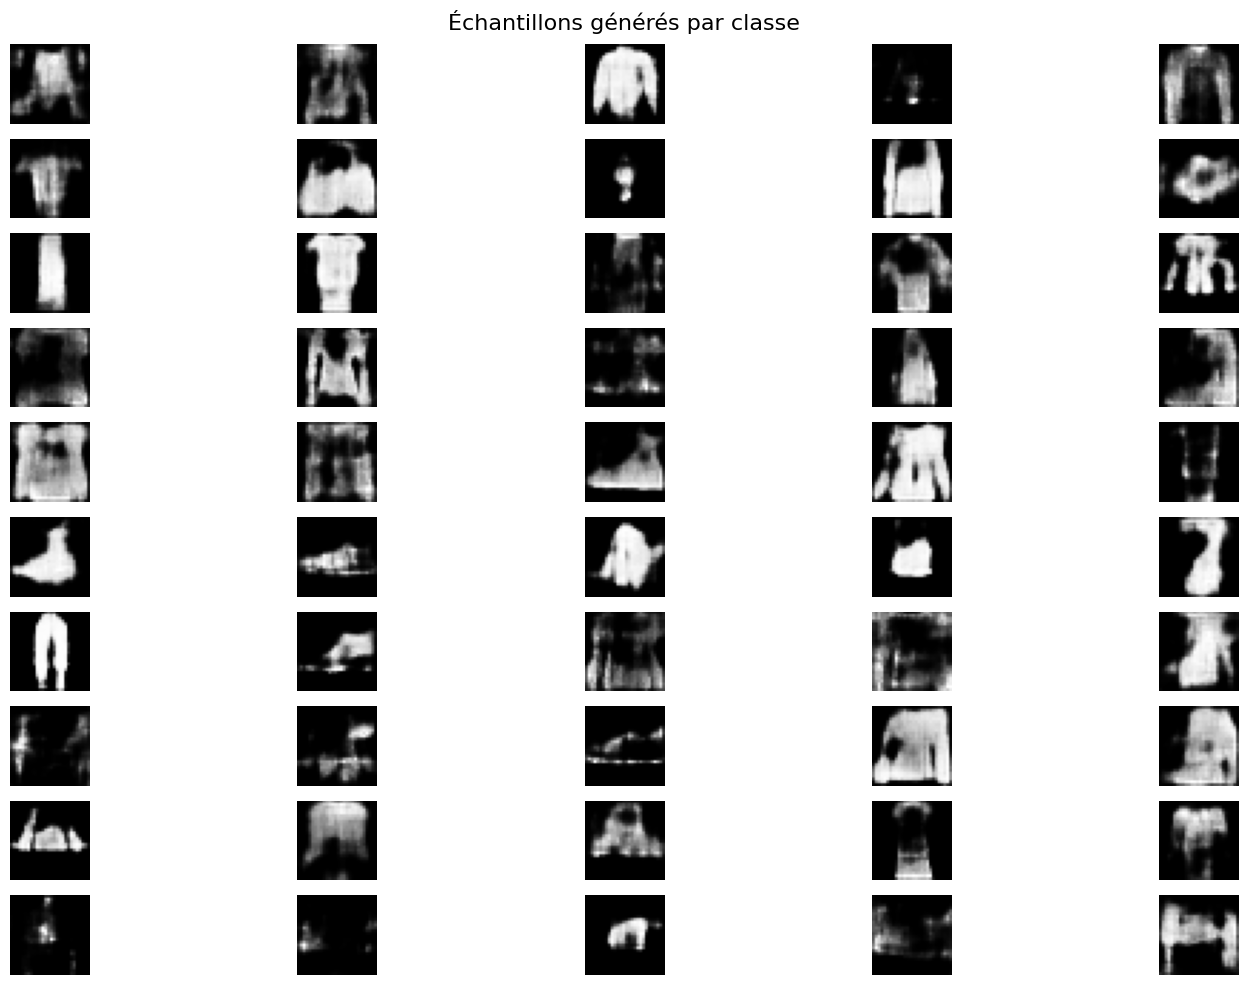

In [92]:
generate_and_plot_samples(cvae)

Même si l'espace latent appris semble bon et permet une bonne séparation des classes, la génération d'échantillons est mauvaise. Cela est certainement dû à l'incohérence dans la structure de l'espace dans lequel sont projetées nos données. En effet, l'espace permet peut-être de bien séparer les classes mais peut présenter une structure chaotique, incohérente rendant compliqué la génération d'une classe en particulier. 

## **Entrainement et génération d'échantillons sans *loss InfoNCE***

Pour résoudre ce problème de génération de nouveaux échantillons, on a retiré la *InfoNCE loss* et relancé un nouvel entrainement.

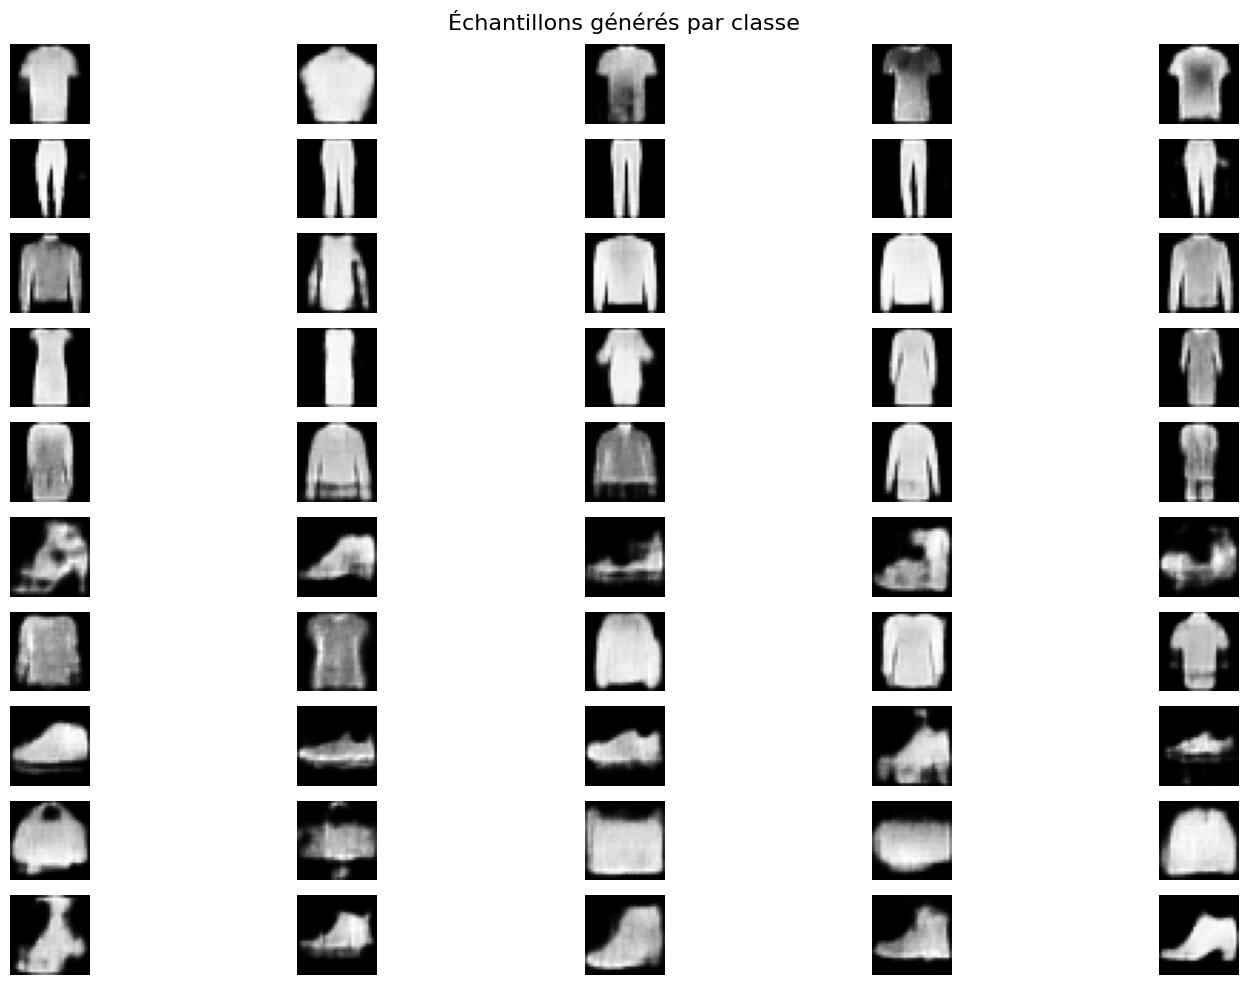

In [93]:
cvae2 = ConvCVAE()
optimizer2 = torch.optim.Adam(cvae2.parameters(), lr=LEARNING_RATE)

# Fonction Train
train_loss, val_loss = train_model(
    model=cvae2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer2,
    scheduler=None,
    save_model=True,
    max_epochs=15,
    save_path="cvae_weights_2.pt",
)

generate_and_plot_samples(cvae2)

Les performances lors de la génération de nouveaux échantillons sont meilleures comme constaté ci-dessus. De plus, le modèle permet de générer des exemples très pertinents dans certains cas. Par exemple, pour les pantalons, le modèle génère des formes très variées, toutes cohérentes. Concernant les chaussures, les nouveaux échantillons sont aussi intéressants. Concernant les classes restantes, le modèle manque *d'originalité* mais reste fidèle à l'aspect global des habits.